In [74]:
# Calculates performance of two models

In [75]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


In [76]:
# name of dir where test data lies
data_dir = 'augmented_data'
filename_model1 = "CLASSES_5_BATCHSIZE_10_EPOCHS_2_IMAGES_{'train': 2700, 'val': 660}"
filename_model2 = "FT_CLASSES_5_BATCHSIZE_10_EPOCHS_2_IMAGES_{'train': 2700, 'val': 660}"

In [78]:
# Data loading

BATCH_SIZE = 4

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [79]:
class_names = image_datasets['test'].classes
class_names

['Enzo', 'GerretLight', 'HazzBerry', 'M10', 'M14']

In [80]:
# Load trained models
# 1: model, weights frozen
# 2: model, weights not frozen

#model_t1 = torch.load("FREEZEWEIGHTS_True_CLASSES_5_BATCHSIZE_10_EPOCHS_2_IMAGES_{'train': 2700, 'val': 660}")
#model_t2 = torch.load("FREEZEWEIGHTS_False_CLASSES_5_BATCHSIZE_10_EPOCHS_2_IMAGES_{'train': 2700, 'val': 660}")

model_t1 = torch.load(filename_model1)
model_t2 = torch.load(filename_model2)

In [81]:
# Model without last fc layer
model_v1 = torch.nn.Sequential(*list(model_t1.children())[:-1])
model_v2 = torch.nn.Sequential(*list(model_t2.children())[:-1])

In [82]:
def get_pred_matrix(model_t):
    # Remember pred counts of class per class
    num_classes = len(image_datasets['test'].classes)
    pred_matrix = np.zeros((num_classes,num_classes))

# Example:
# pred_matrix =
#                       predicted
#                   class_0  class_1
# real    class_0    5         2
#         class_1    0         4
# (7 real class_0 imgs, 5 were predicted class 0, 2 were predicted class 1)
# (4 real class_1 imgs, 0 were predicted class 0, 4 were predicted class 1)


    t0 = time.time()
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_t(inputs)
        _, preds = torch.max(outputs, 1)
        #print(labels)
        #print(preds)
    
        for b in range(0, inputs.shape[0]):
            pred_matrix[labels[b]][preds[b]] = pred_matrix[labels[b]][preds[b]] + 1

    t1 = time.time()
    print('Time taken is: {:.0f}m {:.0f}s'.format((t1-t0) // 60, (t1-t0) % 60))

    return pred_matrix

pred_matrix1 = get_pred_matrix(model_t1)
pred_matrix2 = get_pred_matrix(model_t2)
print("pred_matrix1:")
print(pred_matrix1)
total_acc1 = np.sum(np.diag(pred_matrix1)) / np.sum(pred_matrix1)
print("total_acc1: " + str(total_acc1))

print("pred_matrix2:")
print(pred_matrix2)
total_acc2 = np.sum(np.diag(pred_matrix2)) / np.sum(pred_matrix2)
print("total_acc2: " + str(total_acc2))

Time taken is: 1m 23s
Time taken is: 1m 22s
pred_matrix1:
[[ 130.    1.    0.    1.    0.]
 [  44.   70.    5.   11.    2.]
 [   5.    0.  124.    3.    0.]
 [   5.    5.    1.  121.    0.]
 [   5.    0.    0.    0.  127.]]
total_acc1: 0.866666666667
pred_matrix2:
[[ 132.    0.    0.    0.    0.]
 [   0.  132.    0.    0.    0.]
 [   0.    0.  132.    0.    0.]
 [   0.    0.    0.  132.    0.]
 [   0.    0.    0.    0.  132.]]
total_acc2: 1.0


In [83]:
# For class i:
# Precision_i = TP_i / (TP_i + FP_i)
# Recall_i = TP_i / (TP_i + FN_i)

In [84]:
def calc_scores(pred_matrix):
    num_classes = pred_matrix.shape[0]
    
    # Precision/recall scores for each class
    precision_scores = np.diag(pred_matrix) / np.sum(pred_matrix, axis=0)
    recall_scores = np.diag(pred_matrix) / np.sum(pred_matrix, axis=1)
    
    # F1 scores for each class
    F1_scores = np.zeros(num_classes)
    for k in range(0,num_classes):
        F1_scores[k] = 2 * precision_scores[k]*recall_scores[k] / (precision_scores[k] + recall_scores[k])

    # Combined micro/macro F1 score
    F1_score_micro = np.sum(np.diag(pred_matrix)) / np.sum(pred_matrix) # (= accuracy)
    F1_score_macro = 1/num_classes * np.sum(F1_scores)
    
    return precision_scores,recall_scores,F1_scores,F1_score_micro,F1_score_macro

In [85]:
print("For model1:")
precision_scores1,recall_scores1,F1_scores1,F1_score_micro1,F1_score_macro1 = calc_scores(pred_matrix1)

print("Precision scores for the classes are: " + str(precision_scores1))
print("Recall scores for the classes are: " + str(recall_scores1))
print("F1 scores for the classes are: " + str(F1_scores1))

print("F1 score (micro) / accuracy is: " + str(F1_score_micro1))
print("F1 score (macro) is: " + str(F1_score_macro1))

For model1:
Precision scores for the classes are: [ 0.68783069  0.92105263  0.95384615  0.88970588  0.98449612]
Recall scores for the classes are: [ 0.98484848  0.53030303  0.93939394  0.91666667  0.96212121]
F1 scores for the classes are: [ 0.80996885  0.67307692  0.94656489  0.90298507  0.97318008]
F1 score (micro) / accuracy is: 0.866666666667
F1 score (macro) is: 0.861155161436


In [86]:
print("For model2:")
precision_scores2,recall_scores2,F1_scores2,F1_score_micro2,F1_score_macro2 = calc_scores(pred_matrix2)

print("Precision scores for the classes are: " + str(precision_scores2))
print("Recall scores for the classes are: " + str(recall_scores2))
print("F1 scores for the classes are: " + str(F1_scores2))

print("F1 score (micro) / accuracy is: " + str(F1_score_micro2))
print("F1 score (macro) is: " + str(F1_score_macro2))

For model2:
Precision scores for the classes are: [ 1.  1.  1.  1.  1.]
Recall scores for the classes are: [ 1.  1.  1.  1.  1.]
F1 scores for the classes are: [ 1.  1.  1.  1.  1.]
F1 score (micro) / accuracy is: 1.0
F1 score (macro) is: 1.0


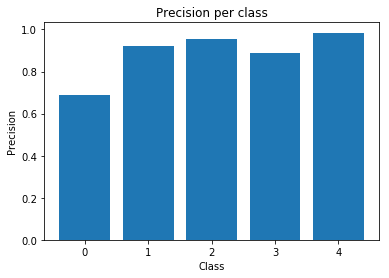

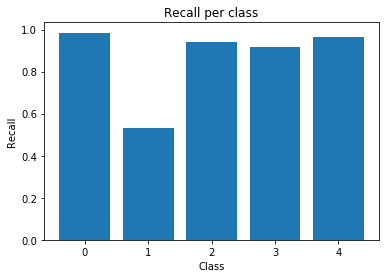

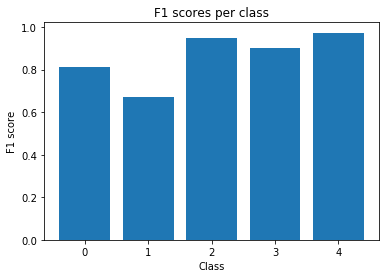

In [87]:
num_classes = pred_matrix1.shape[0]

plt.xlabel("Class")
plt.ylabel("Precision")
plt.title("Precision per class")
plt.bar(np.arange(0,num_classes),precision_scores1)
plt.show()

plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Recall per class")
plt.bar(np.arange(0,num_classes),recall_scores1)
plt.show()

plt.xlabel("Class")
plt.ylabel("F1 score")
plt.title("F1 scores per class")
plt.bar(np.arange(0,num_classes),F1_scores1)
plt.show()

In [88]:
from sklearn.manifold import TSNE

In [89]:
def get_feature_vectors_and_labels(model_v):
    X = []  # Feature vectors
    L = []  # Labels
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model_v(inputs).data.numpy()#np.array(model_v(inputs))
    
        for b in range(0, inputs.shape[0]):
            X.append(np.array(outputs[b]).reshape(-1))
            L.append(int(labels[b]))
    
    return X,L

def calc_projections(model_v):
    X,L = get_feature_vectors_and_labels(model_v)
    
    # Get (N-dim) features for each data point
    X_embedded = TSNE(n_components=2,n_iter=1000).fit_transform(X)
    #X_embedded = TSNE(n_components=2,n_iter=2000).fit_transform(X)
    
    return X,L,X_embedded

In [90]:
###############
# Other projection methods

In [42]:
# Get (N-dim) features for each data point
X_embedded = TSNE(n_components=2,n_iter=2000).fit_transform(X)
X_embedded.shape

(660, 2)

In [19]:
from sklearn import manifold
X_embedded = manifold.LocallyLinearEmbedding().fit_transform(X)
X_embedded.shape

(600, 2)

In [28]:
from sklearn import manifold
X_embedded = manifold.Isomap().fit_transform(X)
X_embedded.shape

(600, 2)

In [30]:
from sklearn import manifold
X_embedded = manifold.MDS().fit_transform(X)
X_embedded.shape

/home/michael/anaconda3/envs/projai/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


(600, 2)

In [63]:
###########

In [91]:
t0 = time.time()
X,L,X_embedded = calc_projections(model_v1)
t1 = time.time()
print('Time taken is: {:.0f}m {:.0f}s'.format((t1-t0) // 60, (t1-t0) % 60))

Time taken is: 1m 41s


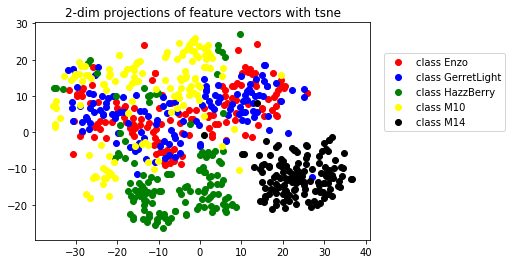

In [92]:
# Create scatter plot of X_embedded with color per label
from matplotlib import pyplot as plt

# dict
X_c = {}
num_classes = len(class_names)
class_colors = ['red','blue','green','yellow','black']

# initialize
for k in range(0,num_classes):
    X_c[k] = []

# fill in
for k in range(0,X_embedded.shape[0]):
    X_c[L[k]].append(X_embedded[k])

# plot
for k in range(0,num_classes):
    x_c,y_c = zip(*X_c[k])
    plt.scatter(x_c,y_c,color=class_colors[k],label="class "+class_names[k])

plt.legend(loc=(1.04,0.5))
plt.title("2-dim projections of feature vectors with tsne")
plt.show()

In [93]:
t0 = time.time()
X,L,X_embedded = calc_projections(model_v2)
t1 = time.time()
print('Time taken is: {:.0f}m {:.0f}s'.format((t1-t0) // 60, (t1-t0) % 60))

Time taken is: 1m 30s


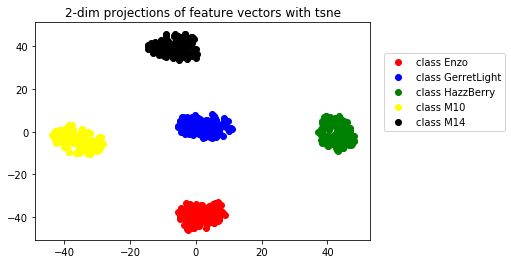

In [94]:
# Create scatter plot of X_embedded with color per label
from matplotlib import pyplot as plt

# dict
X_c = {}
num_classes = len(class_names)
class_colors = ['red','blue','green','yellow','black']

# initialize
for k in range(0,num_classes):
    X_c[k] = []

# fill in
for k in range(0,X_embedded.shape[0]):
    X_c[L[k]].append(X_embedded[k])

# plot
for k in range(0,num_classes):
    x_c,y_c = zip(*X_c[k])
    plt.scatter(x_c,y_c,color=class_colors[k],label="class "+class_names[k])

plt.legend(loc=(1.04,0.5))
plt.title("2-dim projections of feature vectors with tsne")
plt.show()